In [102]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

While - like PCA - clutering methods are unsupervsied, the requirements for this project specify that a labeled dataset must be used in the following analysis. Because I am most interested in understanding the factors contributing most to paper impact, I will use citation count as the label. 

,author_count,year,read_count,download_count,Journal_Rank
0,-0.342659,0.399746,15.781133,0.691080,-0.718531
1,0.411490,0.191319,5.439945,4.147883,-0.405238
2,-0.342659,1.025027,1.420615,-0.940852,-0.207979
3,0.746667,-0.642389,6.174266,3.974185,-0.405238
4,-0.334280,-1.267670,3.746686,2.386458,-0.527074
...,...,...,...,...,...
987,-0.346849,-1.684524,-0.096406,0.183506,-0.614100
988,-0.149932,-1.892951,0.557356,0.672878,-0.422643
989,-0.296572,-1.892951,0.151535,0.377487,-0.440048
990,-0.330090,-1.892951,0.280474,0.536624,3.313671


,PC1,PC2,PC3
0,9.559898,1.406500,0.259452
1,5.698700,0.857278,0.317748
2,-0.273832,0.105168,-0.203346
3,6.467614,1.099117,0.477560
4,4.349882,0.079792,-0.449774
...,...,...,...
987,0.937388,-0.152780,-0.842486
988,1.734566,-0.090241,-0.543223
989,1.308761,-0.221149,-0.668931
990,1.388870,-2.344612,2.431558


Total variance explained by 3 components: 0.87


Text(0.5, 0, 'Component 3')

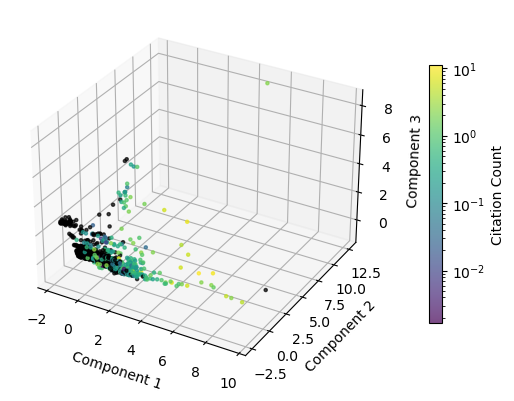

In [103]:
'''
Split, scale, and transform the data
    - NOTE: No additional scaling needed; data is already scaled to standard normal 
'''

# Split data
data = pd.read_csv('../ads_data_clean.csv')
X = data.drop(columns=['citation_count','doi', 'bibcode', 'aff', 'bibstem','arxiv_class'])
y = data['citation_count']
display(X)

# Transform to 3D using PCA
model = PCA(n_components=3) 
model.fit(X)
X_pca = model.transform(X)
display(pd.DataFrame(X_pca, columns=['PC1','PC2','PC3']))
print(f"Total variance explained by 3 components: {np.round(model.explained_variance_ratio_.sum(),2)}")
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
im = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], s=5, alpha=0.7, c=y, norm=colors.LogNorm(), zorder=1)
fig.colorbar(im, ax=ax, label='Citation Count', shrink=0.7, pad=0.1)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

Most optimal numbers of clusters: [4, 5, 6]


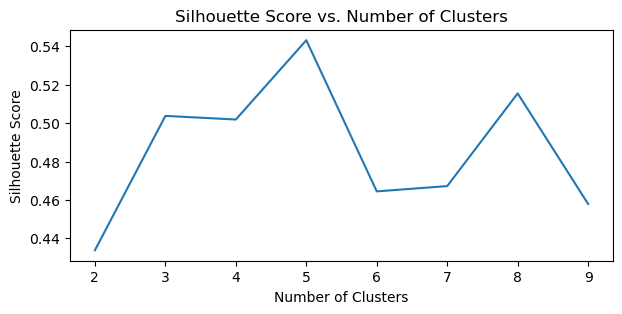

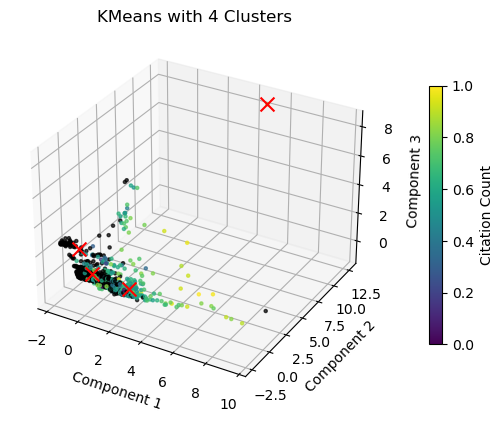

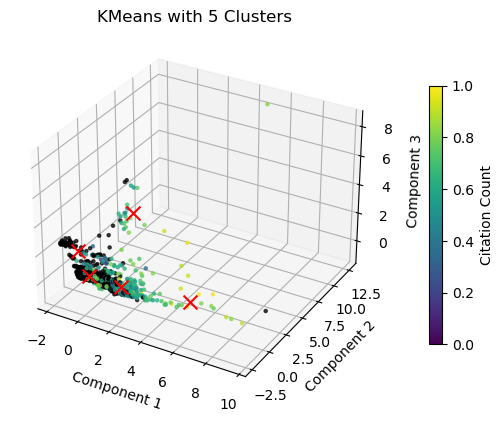

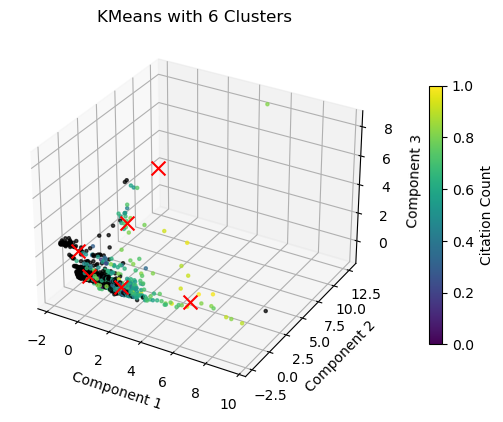

In [106]:
'''
Partitional Clustering (KMeans)
'''

# Sihloette Method to determine optimal number of clusters
ks = range(2, 10)
scores = []
for k in ks:
    model = KMeans(n_clusters=k, n_init='auto')
    model.fit(X_pca)
    labels = model.labels_
    score = silhouette_score(X_pca, labels)
    scores.append(score)
best_ks = [4,5,6] # np.array(ks)[list(np.argsort(scores))[::-1][:3]]
print(f"Most optimal numbers of clusters: {best_ks}")
fig = plt.figure(figsize=(7,3))
plt.plot(ks, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')

# Clustering with optimal number of clusters
for k in best_ks:
    model = KMeans(n_clusters=k, n_init='auto')
    model.fit(X_pca)
    labels = model.labels_
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d', computed_zorder=False)
    ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], s=5, alpha=0.7, c=y, norm=colors.LogNorm(), zorder=0)
    im = ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], model.cluster_centers_[:,2], s=100, c='r', marker='x', label='Centroids', depthshade=False, zorder=2)
    fig.colorbar(im, ax=ax, label='Citation Count', shrink=0.7, pad=0.1)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.set_title(f'KMeans with {k} Clusters')

# Save cluster centers for further analysis
model = KMeans(n_clusters=5, n_init='auto')
model.fit(X_pca)
KMeans_center_1 = model.cluster_centers_[0]
KMeans_center_2 = model.cluster_centers_[1]
KMeans_center_3 = model.cluster_centers_[2]
KMeans_center_4 = model.cluster_centers_[3]
kmeans_centers = np.vstack((KMeans_center_1, KMeans_center_2, KMeans_center_3, KMeans_center_4))


Text(0.5, 0.92, 'Agglomorative Clustering Clusters')

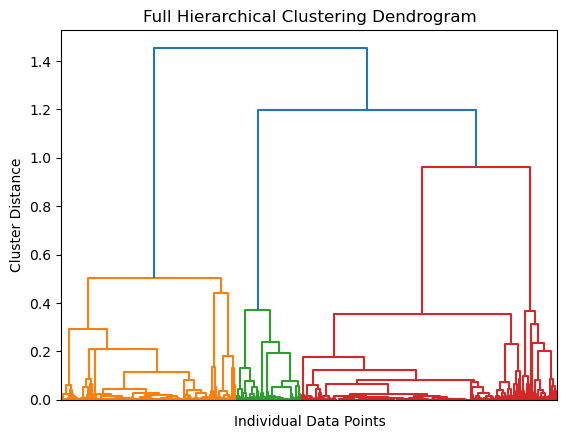

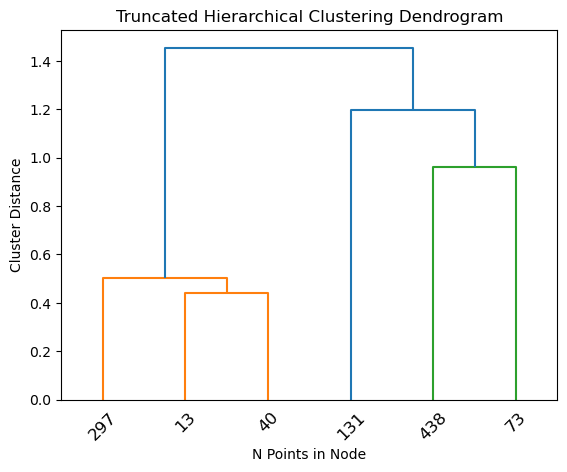

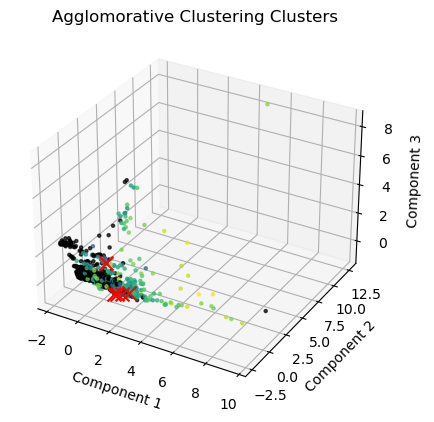

In [107]:
'''
Hierarchical Clustering (Agglomerative)
'''

# Fit model - set distance threshold instead of n clusters
model = AgglomerativeClustering(distance_threshold=0, linkage='average', metric='cosine', n_clusters=None) # AgglomerativeClustering(n_clusters=3)
model.fit_predict(X_pca)
labels = model.labels_

# Define function to plot dendrogram
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    R = dendrogram(linkage_matrix, **kwargs)
    return R

# Plot full dendrogram
plt.figure()
plt.title("Full Hierarchical Clustering Dendrogram")
R = plot_dendrogram(model)
ax = plt.gca()
lbls = ['' for s in R['ivl']] 
ax.set_xticklabels(lbls)
plt.ylabel('Cluster Distance')
plt.xlabel("Individual Data Points")

# Plot dendrogram with horizantal cutoff
plt.figure()
plt.title("Truncated Hierarchical Clustering Dendrogram")
R = plot_dendrogram(model, truncate_mode="lastp", p=6)
ax = plt.gca()
lbls = [f'{s[1:-1]}' if '(' in s else '1' for s in R['ivl']]
ax.set_xticklabels(lbls, rotation=45)
plt.ylabel('Cluster Distance')
plt.xlabel("N Points in Node")

# Plot clusters
fig = plt.figure()
ax = fig.add_subplot(projection='3d', computed_zorder=False)
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], s=5, alpha=0.7, c=y, norm=colors.LogNorm(), zorder=0)
unique_labels = np.unique(labels)
hclust_center_1 = np.mean(X_pca[labels==unique_labels[0]], axis=0)
hclust_center_2 = np.mean(X_pca[labels==unique_labels[1]], axis=0)
hclust_center_3 = np.mean(X_pca[labels==unique_labels[2]], axis=0)
hclust_center_4 = np.mean(X_pca[labels==unique_labels[3]], axis=0)
hclust_center_5 = np.mean(X_pca[labels==unique_labels[4]], axis=0)
hclust_centers = np.vstack([hclust_center_1, hclust_center_2, hclust_center_3, hclust_center_4, hclust_center_5])
im = ax.scatter(hclust_centers[:,0], hclust_centers[:,1], hclust_centers[:,2], s=100, c='r', marker='x', label='Centroids', depthshade=False, zorder=2)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('Agglomorative Clustering Clusters')

Text(0.5, 0.92, 'DBSCAN Clusters')

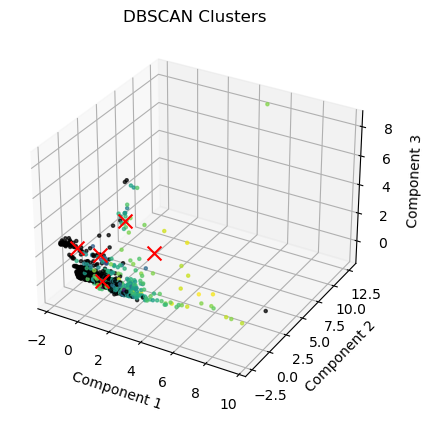

In [108]:
'''
Density-Based Clustering (DBSCAN)
'''

model = DBSCAN(eps=0.5, min_samples=5)
model.fit(X_pca)
labels = model.labels_

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], s=10, alpha=0.4, c=labels)
# ax.set_xlabel('Component 1')
# ax.set_ylabel('Component 2')
# ax.set_zlabel('Component 3')
# ax.set_title('DBSCAN Clusters')

# Plot clusters
fig = plt.figure()
ax = fig.add_subplot(projection='3d', computed_zorder=False)
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], s=5, alpha=0.7, c=y, norm=colors.LogNorm(), zorder=0)
unique_labels = np.unique(labels)
dbscan_center_1 = np.mean(X_pca[labels==unique_labels[0]], axis=0)
dbscan_center_2 = np.mean(X_pca[labels==unique_labels[1]], axis=0)
dbscan_center_3 = np.mean(X_pca[labels==unique_labels[2]], axis=0)
dbscan_center_4 = np.mean(X_pca[labels==unique_labels[3]], axis=0)
dbscan_center_5 = np.mean(X_pca[labels==unique_labels[4]], axis=0)
dbscan_centers = np.vstack([dbscan_center_1, dbscan_center_2, dbscan_center_3, dbscan_center_4, dbscan_center_5])
im = ax.scatter(dbscan_centers[:,0], dbscan_centers[:,1], dbscan_centers[:,2], s=100, c='r', marker='x', label='Centroids', depthshade=False, zorder=2)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('DBSCAN Clusters')

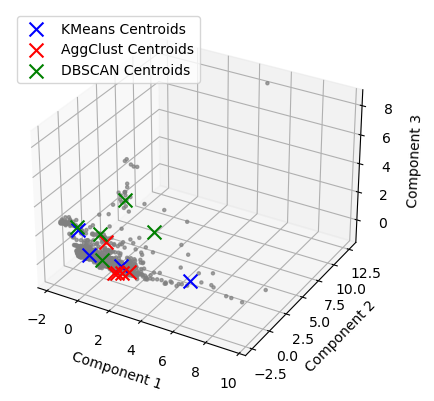

In [114]:
'''
Comparison of Clustering Methods
'''

fig = plt.figure()
ax = fig.add_subplot(projection='3d', computed_zorder=False)
ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], s=5, alpha=0.7, zorder=0, c='Grey') #c=y, cmap='Greys', norm=colors.LogNorm())
unique_labels = np.unique(labels)
im = ax.scatter(kmeans_centers[:,0], kmeans_centers[:,1], kmeans_centers[:,2], s=100, c='b', marker='x', label='KMeans Centroids', depthshade=False, zorder=2)
im = ax.scatter(hclust_centers[:,0], hclust_centers[:,1], hclust_centers[:,2], s=100, c='r', marker='x', label='AggClust Centroids', depthshade=False, zorder=2)
im = ax.scatter(dbscan_centers[:,0], dbscan_centers[:,1], dbscan_centers[:,2], s=100, c='g', marker='x', label='DBSCAN Centroids', depthshade=False, zorder=2)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.legend()


In [97]:
a = 2
np.round(10*(54 - a)/54 ,1)

9.6